# NNの計算結果検討

In [1]:
#import
import sys
import math

import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
import torchvision
from torchvision import models, transforms

sys.path.append('../')
from pyopt import transmission as tr
from pyopt.util import save_pickle, load_pickle

# 1. 各種関数

### ANN定義

In [2]:
def data_shaping_ANN(input_signal, signal, sampling, tap, max_tap, n):
    x = np.zeros((len(input_signal) // n - (max_tap - 1), sampling * tap * 2), dtype=float)
    y = np.zeros((len(input_signal) // n - (max_tap - 1), 2), dtype=float)
    if sampling == 1:
        for i, center in enumerate(range(max_tap // 2, len(input_signal) // n - max_tap // 2)):
            for j, symbol in enumerate(range(tap)):
                x[i, j * 2] = signal[n * (center - tap // 2 + j) + n // 2].real
                x[i, j * 2 + 1] = signal[n * (center - tap // 2 + j) + n // 2].imag
            y[i, 0] = input_signal[n // 2 + n * center].real
            y[i, 1] = input_signal[n // 2 + n * center].imag
    else:
        for i, center in enumerate(range(max_tap // 2, len(input_signal) // n - max_tap // 2)):
            for j, symbol in enumerate(range(tap)):
                for k, sample in enumerate([round(_ * n / sampling) for _ in range(sampling)]):
                    x[i, j * sampling * 2 + k * 2] = signal[n * (center - tap // 2 + j) + sample].real
                    x[i, j * sampling * 2 + k * 2 + 1] = signal[n * (center - tap // 2 + j) + sample].imag
            y[i, 0] = input_signal[n // 2 + n * center].real
            y[i, 1] = input_signal[n // 2 + n * center].imag
    return x, y


class Dataset_ANN(data.Dataset):
    def __init__(self, x, y, mean, std):
        self.x, self.y, self.mean, self.std = x, y, mean, std
    
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, index):
        x = self.x[index]
        y = self.y[index]
        
        x = (x - self.mean) / self.std
        y = (y - self.mean) / self.std
        return torch.Tensor(x), torch.Tensor(y)


class ANN(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_neuron, activation):
        super(ANN, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_neuron)
        self.fc2 = nn.Linear(hidden_neuron, output_dim)
        if activation == 'ReLU':
            self.activation = F.relu
        elif activation == 'Sigmoid':
            self.activation = torch.sigmoid
    
    def forward(self, x):
        x = self.activation(self.fc1(x))
        x = self.fc2(x)
        return x


def evm_score(y_pred, y_true):
    y_pred = y_pred[:, 0] + y_pred[:, 1] * 1j
    y_true = y_true[:, 0] + y_true[:, 1] * 1j
    symbol, index, inverse, counts = np.unique(y_true, return_index=True, return_inverse=True, return_counts=True)
    
    t_sum = 0
    for i in range(len(index)):
        t_sum += abs(y_true[index[i]])
    mean = t_sum / len(index)
    
    tmp = 0
    for i in range(len(y_pred)):
        tmp += abs(y_pred[i] - y_true[i]) ** 2
    if type(tmp) is np.float64:
        evm = np.sqrt(tmp / len(y_pred)) / mean
    else:
        evm = torch.sqrt(tmp / len(y_pred)) / mean
    return evm


def cal_evm_min(input_signal, output_signal):
    symbol, index, inverse, counts = np.unique(input_signal, return_index=True, return_inverse=True, return_counts=True)

    t_sum = 0
    for i in range(len(index)):
        t_sum += abs(input_signal[index[i]])
    mean = t_sum / len(index)

    evm_min = 200
    i_min = 0
    for i in range(360):
        signal = output_signal * np.exp(1j * i * np.pi/180)
        tmp = 0
        for j in range(len(output_signal)):
            tmp += abs(signal[j] - input_signal[j]) ** 2# / abs(input_signal[j]) ** 2
        evm = np.sqrt(tmp / len(output_signal)) / mean * 100
        if evm < evm_min:
            evm_min = evm
            i_min = i
    return evm_min, i_min

### CVNN定義

In [3]:
def data_shaping_CVNN(input_signal, signal, sampling, tap, max_tap, n):
    x = np.zeros((len(input_signal) // n - (max_tap - 1), sampling * tap, 2), dtype=float)
    y = np.zeros((len(input_signal) // n - (max_tap - 1), 2), dtype=float)
    if sampling == 1:
        for i, center in enumerate(range(max_tap // 2, len(input_signal) // n - max_tap // 2)):
            for j, symbol in enumerate(range(tap)):
                x[i, j * 2, 0] = signal[n * (center - tap // 2 + j) + n // 2].real
                x[i, j * 2, 1] = signal[n * (center - tap // 2 + j) + n // 2].imag
            y[i, 0] = input_signal[n // 2 + n * center].real
            y[i, 1] = input_signal[n // 2 + n * center].imag
    else:
        for i, center in enumerate(range(max_tap // 2, len(input_signal) // n - max_tap // 2)):
            for j, symbol in enumerate(range(tap)):
                for k, sample in enumerate([round(_ * n / sampling) for _ in range(sampling)]):
                    x[i, j * sampling + k, 0] = signal[n * (center - tap // 2 + j) + sample].real
                    x[i, j * sampling + k, 1] = signal[n * (center - tap // 2 + j) + sample].imag
            y[i, 0] = input_signal[n // 2 + n * center].real
            y[i, 1] = input_signal[n // 2 + n * center].imag
    return x, y


class Dataset_CVNN(data.Dataset):
    def __init__(self, x, y, mean, std):
        self.x, self.y, self.mean, self.std = x, y, mean, std
    
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, index):
        x = self.x[index]
        y = self.y[index]
        
        x = (x - self.mean) / self.std
        y = (y - self.mean) / self.std
        
        x = torch.Tensor(x)
        y = torch.Tensor(y)
        
        x_i = x[:, 0]
        x_q = x[:, 1]
        y_i = y[0]
        y_q = y[1]
        return x_i, x_q, y_i, y_q


class CSigmoid(nn.Module):
    def __init__(self):
        super().__init__()
        
    def forward(self, x_i, x_q):
        x_i, x_q = x_i.clone(), x_q.clone()
        x_i, x_q = torch.sigmoid(x_i), torch.sigmoid(x_q)
        return x_i, x_q


class CReLU(nn.Module):
    def __init__(self):
        super().__init__()
        
    def forward(self, x_i, x_q):
        x_i, x_q = x_i.clone(), x_q.clone()
        x_i, x_q = F.relu(x_i), F.relu(x_q)
        return x_i, x_q


class modReLU(nn.Module):
    def __init__(self, in_features):
        super().__init__()
        self.in_features = in_features
        self.b = torch.tensor(-math.sqrt(1 / in_features), requires_grad=True)
    
    def forward(self, x_i, x_q):
        x_i, x_q = x_i.clone(), x_q.clone()
        norm = torch.sqrt(x_i ** 2 + x_q ** 2)
        
        out_i = F.relu(norm + self.b) * x_i / norm
        out_q = F.relu(norm + self.b) * x_q / norm
        return out_i, out_q


class ComplexLinear(nn.Module):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        
        # 重み定義 Xavierの初期値
        k = 1 / in_features
        weight_i = torch.empty(out_features, in_features).uniform_(-math.sqrt(k), math.sqrt(k))
        self.weight_i = nn.Parameter(weight_i)
        weight_q = torch.empty(out_features, in_features).uniform_(-math.sqrt(k), math.sqrt(k))
        self.weight_q = nn.Parameter(weight_q)
        
        bias_i = torch.empty(out_features).uniform_(-k, k)
        self.bias_i = nn.Parameter(bias_i)
        bias_q = torch.empty(out_features).uniform_(-k, k)
        self.bias_q = nn.Parameter(bias_q)
        
    def forward(self, x_i, x_q):
        i = nn.functional.linear(x_i, self.weight_i) - nn.functional.linear(x_q, self.weight_q) + self.bias_i
        q = nn.functional.linear(x_i, self.weight_q) + nn.functional.linear(x_q, self.weight_i) + self.bias_q
        return i, q


class CVNN(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_neuron, activation):
        super().__init__()
        self.fc1 = ComplexLinear(input_dim, hidden_neuron)
        self.fc2 = ComplexLinear(hidden_neuron, output_dim)
        if activation == 'CSigmoid':
            self.activation = CSigmoid()
        elif activation == 'ZReLU':
            self.activation = ZReLU()
        elif activation == 'CReLU':
            self.activation = CReLU()
        elif activation == 'modReLU':
            self.activation = modReLU(input_dim)
    
    def forward(self, x_i, x_q):
        x_i, x_q = self.fc1(x_i, x_q)
        x_i, x_q = self.activation(x_i, x_q)
        x_i, x_q = self.fc2(x_i, x_q)
        return x_i, x_q

### データ読み込み

In [4]:
def load_signal(signal_info, trans_condition, model_type, lc, sampling, tap, max_tap, n, Lmax):
    if model_type == 'ANN':
        data_shaping = data_shaping_ANN
    elif model_type == 'CVNN':
        data_shaping = data_shaping_CVNN
    
    if signal_info['signal_type'] == 'prbs':
        return load_prbs(signal_info, trans_condition, data_shaping, lc, sampling, tap, max_tap, n, Lmax)
    elif signal_info['signal_type'] == 'random':
        return load_random(signal_info, trans_condition, data_shaping, lc, sampling, tap, max_tap, n, Lmax)
    elif signal_info['signal_type'] == 'image':
        return load_image(signal_info, trans_condition, data_shaping, lc, sampling, tap, max_tap, n, Lmax)

In [5]:
def load_prbs(signal_info, trans_condition, data_shaping, lc, sampling, tap, max_tap, n, Lmax):
    N = signal_info['N']
    itr = signal_info['itr']
    signal_condition = 'N=='+str(N)+'&itr=='+str(itr)
    signal_list = [N, itr] + [None] * 6
    
    # prbs.csvをpandasで読み込む
    t_df_dir = '../data/input/'
    t_df = pd.read_csv(t_df_dir + 'prbs.csv', index_col=0)
    
    # prbs.csvにおいて、指定した伝送条件を見たす行を抜き出す
    t_query = t_df.query(signal_condition + '&' + trans_condition)
    
    # if prbs.csvに指定した伝送条件がない or Lmax以外は満たすがLmaxだけ指定した条件未満: 何もしない if ある: 続ける
    if len(t_query) == 0 or t_query.iloc[0]['Lmax'] < Lmax:
        print('指定された伝送条件の信号が存在しません')
        sys.exit()
    else:
        # 伝送信号を学習データに整形する
        sgnl = load_pickle(t_query.iloc[0]['data_path'])
        if lc:
            sgnl_distorted = sgnl.linear_compensation(Lmax, sgnl.signal['x_' + str(Lmax)])
        else:
            sgnl_distorted = sgnl.signal['x_' + str(Lmax)]
        x, y = data_shaping(sgnl.signal['x_0'], sgnl_distorted, sampling, tap, max_tap, n)
        return x, y, signal_condition, signal_list

In [6]:
def load_random(signal_info, trans_condition, data_shaping, lc, sampling, tap, max_tap, n, Lmax):
    seed = signal_info['seed']
    bit_num = signal_info['bit_num']
    signal_condition = 'seed=='+str(seed)+'&bit_num=='+str(bit_num)
    signal_list = [None] * 2 + [seed, bit_num] + [None] * 4
    
    # random.csvをpandasで読み込む
    t_df_dir = '../data/input/'
    t_df = pd.read_csv(t_df_dir + 'random.csv', index_col=0)
    
    # random.csvにおいて、指定した伝送条件を見たす行を抜き出す
    t_query = t_df.query(signal_condition + '&' + trans_condition)
    
    # if random.csvに指定した伝送条件がない or Lmax以外は満たすがLmaxだけ指定した条件未満: 何もしない if ある: 続ける
    if len(t_query) == 0 or t_query.iloc[0]['Lmax'] < Lmax:
        print('指定された伝送条件の信号が存在しません')
        sys.exit()
    else:
        # 伝送信号を学習データに整形する
        sgnl = load_pickle(t_query.iloc[0]['data_path'])
        if lc:
            sgnl_distorted = sgnl.linear_compensation(Lmax, sgnl.signal['x_' + str(Lmax)])
        else:
            sgnl_distorted = sgnl.signal['x_' + str(Lmax)]
        x, y = data_shaping(sgnl.signal['x_0'], sgnl_distorted, sampling, tap, max_tap, n)
        return x, y, signal_condition, signal_list

In [7]:
def load_image(signal_info, trans_condition, data_shaping, lc, sampling, tap, max_tap, n, Lmax):
    target_dir = signal_info['target_dir']
    step = signal_info['step']
    image_number = signal_info['image_number']
    image_number_split = image_number.split(', ')
    ebtb = signal_info['ebtb']
    signal_condition = 'target_dir=="'+str(target_dir)+'"&step=='+str(step)+'&image_number=="'+image_number+'"&ebtb=='+str(ebtb)
    signal_list = [None] * 4 + [target_dir, step, image_number, ebtb]
    
    # image.csvをpandasで読み込む
    t_df_dir = '../data/input/'
    t_df = pd.read_csv(t_df_dir + 'image.csv', index_col=0)
    
    x = None
    y = None
    for i in range(len(image_number_split)):
        # image.csvにおいて、指定した伝送条件を見たす行を抜き出す
        t_query = t_df.query('target_dir=="'+str(target_dir)+'"&step=='+str(step)+'&image_number=='+image_number_split[i]+'&ebtb=='+str(ebtb) + '&' + trans_condition)
        
        # if image.csvに指定した伝送条件がない or Lmax以外は満たすがLmaxだけ指定した条件未満: 何もしない if ある: 続ける
        if len(t_query) == 0 or t_query.iloc[0]['Lmax'] < Lmax:
            print('指定された伝送条件の信号が存在しません')
            sys.exit()
        else:
            # 伝送信号を学習データに整形する
            sgnl = load_pickle(t_query.iloc[0]['data_path'])
            if lc:
                sgnl_distorted = sgnl.linear_compensation(Lmax, sgnl.signal['x_' + str(Lmax)])
                evm_min, i_min = cal_evm_min(sgnl.signal['x_0'][16::32], sgnl_distorted[16::32])
                sgnl_distorted = sgnl_distorted * np.exp(1j * i_min * np.pi/180)
                pr = sgnl.phase_rotation_theo(Lmax)
                sgnl_distorted = sgnl_distorted * np.exp(-1j * pr * np.pi/180)
            else:
                sgnl_distorted = sgnl.signal['x_' + str(Lmax)]
            x_tmp, y_tmp = data_shaping(sgnl.signal['x_0'], sgnl_distorted, sampling, tap, max_tap, n)
            if x is None:
                x = x_tmp
                y = y_tmp
            else:
                x = np.concatenate([x, x_tmp])
                y = np.concatenate([y, y_tmp])
    return x, y, signal_condition, signal_list

In [8]:
def prepare_input(model_info, signal_info, tap, PdBm):
    model_type = model_info['model_type']
    lc = model_info['linear_compensation']
    sampling = model_info['sampling']
    #tap = model_info['tap']
    batch_size = model_info['batch_size']
    neuron = model_info['neuron']
    epochs = model_info['epochs']
    lr = model_info['lr']
    activation = model_info['activation']
    form = model_info['form']
    #PdBm = model_info['PdBm']
    Lmax = model_info['Lmax']
    
    max_tap = 501
    n = 32  # 1シンボルあたりのサンプリング数[/symbol]
    equalize = False  # 各シンボル数を均等にするか
    baudrate = 28  # ボーレート[GBaud]
    Ledfa = 100  # EDFAスパン[km]
    stepedfa = 30  # SSFMの繰り返し計算ステップ数
    gamma = 2.8  # 非線形係数[/W/km]
    D = 16  # 分散パラメータ[ps/nm/km]
    Alpha = 0.16  # 伝送損失[dB/km]
    NF = 4  # ASE雑音指数[dB]
    ase = True  # ASE雑音を考慮するか
    
    # 指定した学習条件と伝送条件
    trans_condition = 'form=="'+str(form)+'"&n=='+str(n)+'&equalize=='+str(equalize)+'&baudrate=='+str(baudrate)+'&PdBm=='+str(PdBm)+'&Ledfa=='+str(Ledfa)+'&stepedfa=='+str(stepedfa)+'&\
                                    gamma=='+str(gamma)+'&D=='+str(D)+'&Alpha=='+str(Alpha)+'&NF=='+str(NF)+'&ase=='+str(ase)
    
    x, y, _, _ = load_signal(signal_info, trans_condition, model_type, lc, sampling, tap, max_tap, n, Lmax)
    return x, y

### Model読み込み

In [9]:
def load_model(learn_condition, trans_condition, signal_condition, model_type, device, sampling, tap, neuron, epochs, activation, Lmax):
    l_df_dir = '../data/params/' + model_type + '.csv'
    l_df = pd.read_csv(l_df_dir, index_col=0)

    # ANN.csvにおいて、指定した条件を満たす行だけqueryとして抜き出す
    l_query = l_df.query(learn_condition + '&' + signal_condition + '&' + trans_condition + '&Lmax=='+str(Lmax))

    #if epochsを含む指定された条件を満たす結果がある: 何もしない
    if len(l_query) == 0 or l_query['epochs'].max() < epochs:
        print('指定された条件の学習結果は存在しません')
    else:
        index = l_query['epochs'].idxmax()
        if model_type == 'ANN':
            model = ANN(input_dim=sampling*tap*2, output_dim=2, hidden_neuron=neuron, activation=activation).to(device)
        elif model_type == 'CVNN':
            model = CVNN(input_dim=sampling*tap, output_dim=1, hidden_neuron=neuron, activation=activation).to(device)
        model.load_state_dict(torch.load(l_query['params_path'][index]))
    return model

In [10]:
def prepare_model(model_info, signal_info, tap, PdBm):
    device = torch.device('cpu') # 'cuda' if torch.cuda.is_available() else 
    # print('Device available now:', device)
    
    model_type = model_info['model_type']
    lc = model_info['linear_compensation']
    sampling = model_info['sampling']
    #tap = model_info['tap']
    batch_size = model_info['batch_size']
    neuron = model_info['neuron']
    epochs = model_info['epochs']
    lr = model_info['lr']
    activation = model_info['activation']
    form = model_info['form']
    #PdBm = model_info['PdBm']
    Lmax = model_info['Lmax']
   
    max_tap = 501
    n = 32  # 1シンボルあたりのサンプリング数[/symbol]
    equalize = False  # 各シンボル数を均等にするか
    baudrate = 28  # ボーレート[GBaud]
    Ledfa = 100  # EDFAスパン[km]
    stepedfa = 30  # SSFMの繰り返し計算ステップ数
    gamma = 2.8  # 非線形係数[/W/km]
    D = 16  # 分散パラメータ[ps/nm/km]
    Alpha = 0.16  # 伝送損失[dB/km]
    NF = 4  # ASE雑音指数[dB]
    ase = True  # ASE雑音を考慮するか
    
    # 指定した学習条件と伝送条件
    learn_condition = 'linear_compensation=='+str(lc)+'&sampling=='+str(sampling)+'&tap=='+str(tap)+'&max_tap=='+str(max_tap)+'&batch_size=='+str(batch_size)+'&neuron=='+str(neuron)+'&epochs=='+str(epochs)+'&learning_rate=='+str(lr)+'&activation=="'+str(activation)+'"'
    trans_condition = 'form=="'+str(form)+'"&n=='+str(n)+'&equalize=='+str(equalize)+'&baudrate=='+str(baudrate)+'&PdBm=='+str(PdBm)+'&Ledfa=='+str(Ledfa)+'&stepedfa=='+str(stepedfa)+'&\
                                    gamma=='+str(gamma)+'&D=='+str(D)+'&Alpha=='+str(Alpha)+'&NF=='+str(NF)+'&ase=='+str(ase)
    
    x, y, signal_condition, _ = load_signal(signal_info, trans_condition, model_type, lc, sampling, tap, max_tap, n, Lmax)
    if x is not None:
        model = load_model(learn_condition, trans_condition, signal_condition, model_type, device, sampling, tap, neuron, epochs, activation, Lmax)
        
        if model is not None:
            # 平均,標準偏差の計算
            mean = np.mean(x)
            std = np.std(x)
            
            return model, mean, std

### 予測

In [11]:
def predict_ANN(x, y, model_info, signal_info, tap, PdBm):
    model, mean, std = prepare_model(model_info, signal_info, tap, PdBm)
    dataset = Dataset_ANN(x=x, y=y, mean=mean, std=std)
    dataloader = data.DataLoader(dataset, batch_size=model_info['batch_size'], shuffle=False)
    
    nnc = np.empty((0, 2), float)
    y = np.empty((0, 2), float)
    for x_bat, y_bat in dataloader:
        out = model(x_bat)
        nnc = np.append(nnc, out.detach().numpy().reshape(-1, 2) * std + mean, axis=0)
        y = np.append(y, (y_bat.detach().numpy().reshape(-1, 2) * std + mean).astype(np.int32), axis=0)
    return nnc, y

In [12]:
def predict_CVNN(x, y, model_info, signal_info, tap, PdBm):
    model, mean, std = prepare_model(model_info, signal_info, tap, PdBm)
    dataset = Dataset_CVNN(x=x, y=y, mean=mean, std=std)
    dataloader = data.DataLoader(dataset, batch_size=model_info['batch_size'], shuffle=False)
    
    nnc_i = np.empty(0, float)
    nnc_q = np.empty(0, float)
    y_i = np.empty(0, float)
    y_q = np.empty(0, float)
    for x_bat_i, x_bat_q, y_bat_i, y_bat_q in dataloader:
        out_i, out_q = model(x_bat_i, x_bat_q)
        nnc_i = np.append(nnc_i, out_i.detach().numpy() * std + mean)
        nnc_q = np.append(nnc_q, out_q.detach().numpy() * std + mean)
        y_i = np.append(y_i, (y_bat_i.detach().numpy() * std + mean).astype(np.int32))
        y_q = np.append(y_q, (y_bat_q.detach().numpy() * std + mean).astype(np.int32))
    
    nnc = np.hstack([nnc_i.reshape(-1, 1), nnc_q.reshape(-1, 1)])
    y = np.hstack([y_i.reshape(-1, 1), y_q.reshape(-1, 1)])
    return nnc, y

### コンスタレーション

In [13]:
def display_constellation(nnc, y):
    evm = round(evm_score(nnc, y) * 100, 2)
    nnc = nnc[:, 0] + nnc[:, 1] * 1j
    y = y[:, 0] + y[:, 1] * 1j
    
    symbol, inverse, counts = np.unique(y, return_inverse=True, return_counts=True)
    cm = plt.get_cmap('rainbow', 16)
    boxdic = {
        'facecolor' : 'white',
        'edgecolor' : 'black',
        'linewidth' : 1}
    fig = plt.figure(figsize=(6, 6))
    ax = fig.add_subplot(1, 1, 1)
    for i in range(len(symbol)):
        ax.plot(nnc[y == symbol[i]].real, nnc[y == symbol[i]].imag, '.', color=[cm(i)[0], cm(i)[1], cm(i)[2]])
    for i in range(len(symbol)):
        ax.plot(y[y == symbol[i]].real, y[y == symbol[i]].imag, 'o', color=[cm(i)[0], cm(i)[1], cm(i)[2]], markersize=10, markeredgewidth=1, markeredgecolor='black')
    ax.text(-100000, 95000, 'EVM: ' + str(evm) + '%', color='black', fontsize=20, bbox=boxdic)
    ax.set_xlim((-110000, 110000))
    ax.set_ylim((-110000, 110000))
    ax.xaxis.set_tick_params(direction='in')
    ax.yaxis.set_tick_params(direction='in')
    plt.tick_params(labelbottom=False,
                    labelleft=False,
                    labelright=False,
                    labeltop=False)
    plt.tick_params(bottom=False,
                    left=False,
                    right=False,
                    top=False)
    plt.subplots_adjust(left=0, bottom=0, right=1, top=1)

# 2. 可視化

## 2.0 伝送シミュレーションの妥当性

In [14]:
def load_transmitted_signal(PdBm):
    form = 'RZ16QAM'
    
    n = 32  # 1シンボルあたりのサンプリング数[/symbol]
    equalize = False  # 各シンボル数を均等にするか
    baudrate = 28  # ボーレート[GBaud]
    Ledfa = 100  # EDFAスパン[km]
    stepedfa = 30  # SSFMの繰り返し計算ステップ数
    gamma = 1.4  # 非線形係数[/W/km]
    D = 16  # 分散パラメータ[ps/nm/km]
    Alpha = 0.16  # 伝送損失[dB/km]
    NF = 4  # ASE雑音指数[dB]
    ase = True  # ASE雑音を考慮するか
    Lmax = 5000
    
    # 指定した学習条件と伝送条件
    signal_condition = 'N=='+str(17)+'&itr=='+str(1)
    trans_condition = 'form=="'+str(form)+'"&n=='+str(n)+'&equalize=='+str(equalize)+'&baudrate=='+str(baudrate)+'&PdBm=='+str(PdBm)+'&Ledfa=='+str(Ledfa)+'&stepedfa=='+str(stepedfa)+'&\
                                    gamma=='+str(gamma)+'&D=='+str(D)+'&Alpha=='+str(Alpha)+'&NF=='+str(NF)+'&ase=='+str(ase)
    
    # prbs.csvをpandasで読み込む
    t_df_dir = '../data/input/'
    t_df = pd.read_csv(t_df_dir + 'prbs.csv', index_col=0)
    
    # prbs.csvにおいて、指定した伝送条件を見たす行を抜き出す
    t_query = t_df.query(signal_condition + '&' + trans_condition)
    
    # if prbs.csvに指定した伝送条件がない or Lmax以外は満たすがLmaxだけ指定した条件未満: 何もしない if ある: 続ける
    if len(t_query) == 0 or t_query.iloc[0]['Lmax'] < Lmax:
        print('指定された伝送条件の信号が存在しません')
        sys.exit()
    else:
        sgnl = load_pickle(t_query.iloc[0]['data_path'])
        return sgnl

In [227]:
PdBms = [-2, -1, 0, 1, 2]
pr = np.zeros((2, len(PdBms)), dtype=float)
for i, PdBm in enumerate(PdBms):
    print(PdBm, end=' ')
    sgnl = load_transmitted_signal(PdBm)
    lc = sgnl.linear_compensation(5000, sgnl.signal['x_5000'])
    pr[0, i] = sgnl.phase_rotation_theo(5000)
    pr[1, i] = sgnl.phase_rotation_simu(5000, lc[16::32])

-2 -1 0 1 2 

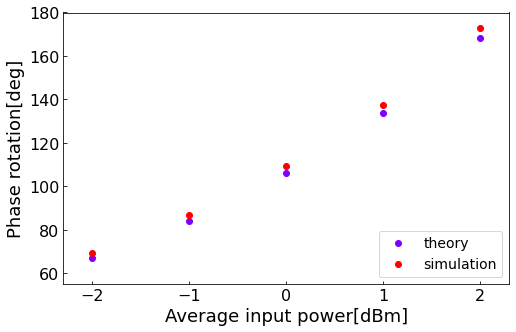

In [228]:
cm = plt.get_cmap('rainbow', 2)
fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot(1, 1, 1)
ax.plot(PdBms, pr[0], 'o', color=[cm(0)[0], cm(0)[1], cm(0)[2]], label='theory')
ax.plot(PdBms, pr[1], 'o', color=[cm(1)[0], cm(1)[1], cm(1)[2]], label='simulation')
plt.legend(fontsize=14, loc='lower right')
plt.xlabel('Average input power[dBm]', fontsize=18)
plt.ylabel('Phase rotation[deg]', fontsize=18)
ax.set_xlim((-2.3, 2.3))
ax.set_ylim((55, 180))
ax.xaxis.set_tick_params(labelsize= 16, direction='in')
ax.yaxis.set_tick_params(labelsize= 16, direction='in')

In [229]:
Ls = [1000, 2000, 3000, 4000, 5000]
pr = np.zeros((2, len(Ls)), dtype=float)
for i, L in enumerate(Ls):
    print(L, end=' ')
    sgnl = load_transmitted_signal(0)
    lc = sgnl.linear_compensation(L, sgnl.signal['x_'+ str(L)])
    pr[0, i] = sgnl.phase_rotation_theo(L)
    pr[1, i] = sgnl.phase_rotation_simu(L, lc[16::32])

1000 2000 3000 4000 5000 

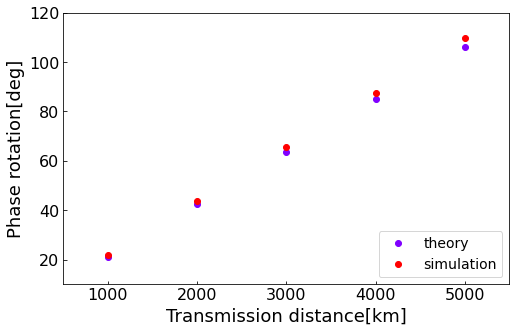

In [268]:
cm = plt.get_cmap('rainbow', 2)
fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot(1, 1, 1)
ax.plot(Ls, pr[0], 'o', lw=3, color=[cm(0)[0], cm(0)[1], cm(0)[2]], label='theory')
ax.plot(Ls, pr[1], 'o', lw=3, color=[cm(1)[0], cm(1)[1], cm(1)[2]], label='simulation')
plt.legend(fontsize=14, loc='lower right')
plt.xlabel('Transmission distance[km]', fontsize=18)
plt.ylabel('Phase rotation[deg]', fontsize=18)
ax.set_xlim((500, 5500))
ax.set_ylim((10, 120))
ax.xaxis.set_tick_params(labelsize= 16, direction='in')
ax.yaxis.set_tick_params(labelsize= 16, direction='in')

## 2.1 コンスタレーション

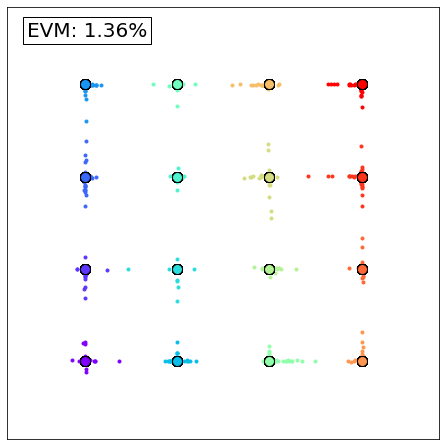

In [162]:
tap = 1
PdBm = 1

model_info = {'model_type': 'ANN',
                          'linear_compensation': True,
                          'sampling': 4,
                          'batch_size': 100,
                          'neuron': 320,
                          'epochs': 500,
                          'lr': 0.001,
                          'activation': 'ReLU',
                          'form': 'RZ16QAM',
                          'Lmax': 2500}

#signal_info_model = {'signal_type': 'prbs', 'N': 17, 'itr': 1}
signal_info_model = {'signal_type': 'random', 'seed': 1234, 'bit_num': 50000}
#signal_info_model = {'signal_type': 'image', 'target_dir': 'train_0', 'step': 10, 'image_number': '0', 'ebtb': True}
#signal_info_model = {'signal_type': 'image', 'target_dir': 'train_0', 'step': 10, 'image_number': '0, 1, 2, 3, 4, 5, 6, 7, 8, 9', 'ebtb': True}

signal_info_input = {'signal_type': 'prbs', 'N': 17, 'itr': 1}
#signal_info_input = {'signal_type': 'random', 'seed': 1234, 'bit_num': 50000}
#signal_info_input = {'signal_type': 'image', 'target_dir': 'train_0', 'step': 10, 'image_number': '0', 'ebtb': True}

x, y = prepare_input(model_info, signal_info_input, tap, PdBm)
nnc, y = predict_ANN(x, y, model_info, signal_info_model, tap, PdBm)
display_constellation(nnc, y)

## 2.2 重み

In [471]:
tap = 501
PdBm = 1

model_info = {'model_type': 'ANN',
                          'linear_compensation': True,
                          'sampling': 4,
                          'batch_size': 100,
                          'neuron': 320,
                          'epochs': 500,
                          'lr': 0.001,
                          'activation': 'ReLU',
                          'form': 'RZ16QAM',
                          'Lmax': 2500}

#signal_info_model = {'signal_type': 'prbs', 'N': 13, 'itr': 1}
signal_info_model = {'signal_type': 'random', 'seed': 1234, 'bit_num': 50000}
#signal_info_model = {'signal_type': 'image', 'target_dir': 'train_0', 'step': 10, 'image_number': '0', 'ebtb': True}
#signal_info_model = {'signal_type': 'image', 'target_dir': 'train_0', 'step': 10, 'image_number': '0, 1, 2, 3, 4, 5, 6, 7, 8, 9', 'ebtb': True}

model, mean, std = prepare_model(model_info, signal_info_model, tap, PdBm)
weight = model.state_dict()['fc1.weight'].detach().numpy()

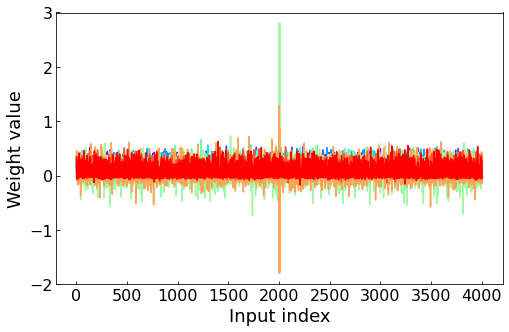

In [486]:
cm = plt.get_cmap('rainbow', 10)
fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot(1, 1, 1)
for i, num in enumerate([7, 25, 60, 98, 140, 160, 179, 226, 250, 289]):
    ax.plot(weight[num], color=[cm(i)[0], cm(i)[1], cm(i)[2]])
plt.xlabel('Input index', fontsize=18)
plt.ylabel('Weight value', fontsize=18)
ax.set_ylim((-2, 3))
ax.xaxis.set_tick_params(labelsize= 16, direction='in')
ax.yaxis.set_tick_params(labelsize= 16, direction='in')

## 2.3 グリッドサーチ

In [15]:
tap = 1
PdBm = 1

model_info = {'model_type': 'ANN',
                          'linear_compensation': True,
                          'sampling': 1,
                          'batch_size': 100,
                          'neuron': 0,
                          'epochs': 0,
                          'lr': 0.001,
                          'activation': 'ReLU',
                          'form': 'RZ16QAM',
                          'Lmax': 2500}

signal_info_model = {'signal_type': 'random', 'seed': 1234, 'bit_num': 50000}

signal_info_input = {'signal_type': 'prbs', 'N': 17, 'itr': 1}

epoch = [50, 100, 150, 200, 250, 300, 350, 400, 450, 500]
neuron = [10, 20, 40, 80, 160, 320, 640, 1280]
evms_grid = np.zeros((8, 10), dtype=float)
for i, n in enumerate(tqdm(neuron)):
    for j, e in enumerate(epoch):
        model_info['neuron'] = n
        model_info['epochs'] = e
        
        x, y = prepare_input(model_info, signal_info_input, tap, PdBm)
        nnc, y = predict_ANN(x, y, model_info, signal_info_model, tap, PdBm)
        evms_grid[i, j] = evm_score(nnc, y) * 100

In [282]:
print(evms_grid)

[[12.05881464 11.78910451 11.71606654 11.64277688 11.54936085 11.47232571
  11.43127711 11.39732805 11.34148074 11.24560553]
 [11.50091611 10.3059913   8.92774825  7.29186701  4.72235439  3.53362157
   3.04209103  2.8241094   2.5811573   2.38409869]
 [ 9.66738554  6.90778226  5.80034913  5.25359262  4.31597768  3.13046554
   2.72707534  2.48067336  2.37127506  2.21740011]
 [ 5.78307737  2.61710468  2.13010619  2.09632305  2.17887593  1.83696487
   1.82770224  1.77613025  1.873037    1.71071409]
 [ 4.42406927  2.33279818  2.03492951  1.90458111  1.95549893  1.80413386
   1.9847026   1.81311145  1.73710789  1.69524714]
 [ 3.04625144  2.12452497  1.94776169  1.90997835  1.88541502  1.8847538
   1.89491011  1.77770992  1.78823651  1.79861709]
 [ 2.53923755  2.38936378  2.08450974  2.75295869  1.96689675  2.02991165
   2.07337837  1.83187049  1.81170863  2.60298893]
 [ 2.72697488  2.41610055  3.28720834  2.20073996  2.43217042  2.40399725
   2.00342032  1.87726666  2.20997175  1.80006599]]


No handles with labels found to put in legend.


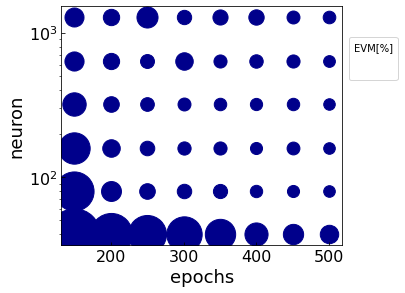

In [159]:
epoch = [50, 100, 150, 200, 250, 300, 350, 400, 450, 500]
neuron = [10, 20, 40, 80, 160, 320, 640, 1280]

fig, ax = plt.subplots()
ax.set_yscale('log')
ax.set_xlabel('epochs', fontsize=18)
ax.set_ylabel('neuron', fontsize=18)
flag = [True, True, True]
evms_sort = np.sort(evms.reshape(-1))
for i in range(2, 8):
    for j in range(8):
        if evms_grid[i][j] == evms_sort[5] and flag[0]:
            ax.scatter(epoch[j], neuron[i], c='darkblue', s=25 + (evms_grid[i][j] - 2) * 1500 / 7, label='{0}%'.format(np.round(evms_grid[i][j], decimals=1)))
            flag[0] = False
        elif evms_grid[i][j] == evms_sort[32] and flag[1]:
            ax.scatter(epoch[j], neuron[i], c='darkblue', s=25 + (evms_grid[i][j] - 2) * 1500 / 7, label='{0}%'.format(np.round(evms_grid[i][j], decimals=1)))
            flag[1] = False
        elif evms_grid[i][j] == evms_sort[-5] and flag[2]:
            ax.scatter(epoch[j], neuron[i], c='darkblue', s=25 + (evms_grid[i][j] - 2) * 1500 / 7, label='{0}%'.format(np.round(evms_grid[i][j], decimals=1)))
            flag[2] = False
        else:
            ax.scatter(epoch[j], neuron[i], c='darkblue', s=25 + (evms_grid[i][j] - 2) * 1500 / 7)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.legend(fontsize=14, bbox_to_anchor=(1.0, 0.9), labelspacing=1.8, prop={'size': 13}, title="EVM[%]")
ax.xaxis.set_tick_params(labelsize=16, direction='in')
ax.yaxis.set_tick_params(labelsize=16, direction='in')
plt.subplots_adjust(left=0.13, bottom=0.15, right=0.78, top=0.98)

In [283]:
epoch = [50, 100, 150, 200, 250, 300, 350, 400, 450, 500]
evms_grid_df = pd.DataFrame(data=evms_grid, index=neuron, columns=epoch, dtype='float')

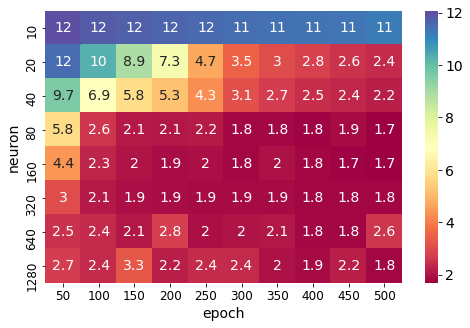

In [284]:
fig, ax = plt.subplots(figsize=(8, 5))
sns.heatmap(evms_grid_df, cmap='Spectral', annot=True, annot_kws={"size":14}, ax=ax)
ax.set_xlabel('epoch', fontsize=14)
ax.set_ylabel('neuron', fontsize=14)
ax.tick_params(labelsize=12)
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=14);

## 2.4 入力シンボル数 vs EVM

### 線形補償0%でNN補償 or 線形補償100%でNN補償

In [135]:
model_info = {'model_type': 'ANN',
                          'linear_compensation': True,
                          'sampling': 1,
                          'batch_size': 100,
                          'neuron': 10,
                          'epochs': 500,
                          'lr': 0.001,
                          'activation': 'ReLU',
                          'form': 'RZ16QAM',
                          'Lmax': 2500}
signal_info_model = {'signal_type': 'random', 'seed': 1234, 'bit_num': 50000}

signal_info_test = {'signal_type': 'prbs', 'N': 17, 'itr': 1}

In [136]:
taps = [1, 51, 101, 151, 201, 251, 301, 351, 401, 451, 501]
evms = np.zeros((4, 11), dtype=float)
for i, tap in enumerate(tqdm(taps)):
    model_info['linear_compensation'] = True
    
    x_model, y_model = prepare_input(model_info, signal_info_model, tap, PdBm)
    x_test, y_test = prepare_input(model_info, signal_info_test, tap, PdBm)
    
    nnc, y = predict_ANN(x_model, y_model, model_info, signal_info_model, tap, PdBm)
    evms[0, i] = evm_score(nnc, y) * 100
    
    nnc, y = predict_ANN(x_test, y_test, model_info, signal_info_model, tap, PdBm)
    evms[1, i] = evm_score(nnc, y) * 100
    
    model_info['linear_compensation'] = False
    
    x_model, y_model = prepare_input(model_info, signal_info_model, tap, PdBm)
    x_test, y_test = prepare_input(model_info, signal_info_test, tap, PdBm)
    
    nnc, y = predict_ANN(x_model, y_model, model_info, signal_info_model, tap, PdBm)
    evms[2, i] = evm_score(nnc, y) * 100
    
    nnc, y = predict_ANN(x_test, y_test, model_info, signal_info_model, tap, PdBm)
    evms[3, i] = evm_score(nnc, y) * 100

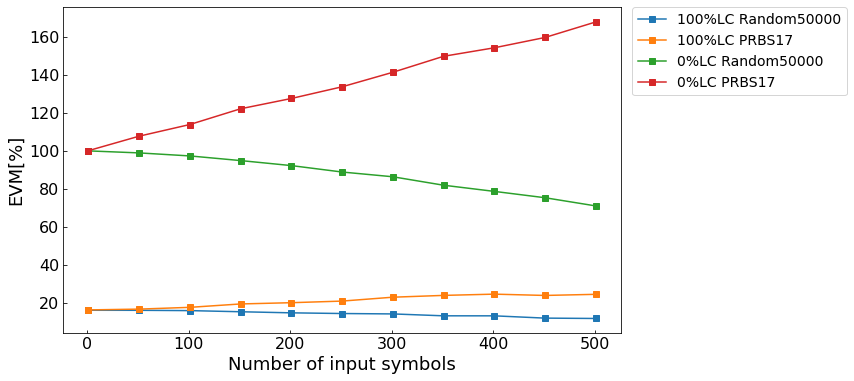

In [137]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)
legends = ['100%LC Random50000', '100%LC PRBS17', '0%LC Random50000', '0%LC PRBS17']
for i in range(4):
    ax.plot(taps, evms[i], '-s', label=legends[i])
plt.legend(fontsize=14, bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.xlabel('Number of input symbols', fontsize=18)
plt.ylabel('EVM[%]', fontsize=18)
#ax.set_xlim((-110000, 110000))
#ax.set_ylim((-110000, 110000))
ax.xaxis.set_tick_params(labelsize= 16, direction='in')
ax.yaxis.set_tick_params(labelsize= 16, direction='in')

### samplingの違い

In [587]:
model_info = {'model_type': 'ANN',
                          'linear_compensation': True,
                          'sampling': 4,
                          'batch_size': 100,
                          'neuron': 320,
                          'epochs': 500,
                          'lr': 0.001,
                          'activation': 'ReLU',
                          'form': 'RZ16QAM',
                          'Lmax': 2500}
signal_info_model0 = {'signal_type': 'random', 'seed': 1234, 'bit_num': 50000}
signal_info_model1 = {'signal_type': 'random', 'seed': 1234, 'bit_num': 500000}
signal_info_model2 = {'signal_type': 'image', 'target_dir': 'train_0', 'step': 60, 'image_number': '0, 5, 6, 12, 17, 33, 35, 45, 52, 53', 'ebtb': True}
signal_info_model3 = {'signal_type': 'image', 'target_dir': 'train_0', 'step': 19, 'image_number': '0, 5, 6, 12, 17, 33, 35, 45, 52, 53', 'ebtb': True}

signal_info_test0 = {'signal_type': 'prbs', 'N': 17, 'itr': 1}
signal_info_test1 = {'signal_type': 'image', 'target_dir': 'train_0', 'step': 60, 'image_number': '10, 11, 13', 'ebtb': True}

In [591]:
PdBm = 1
taps = [1, 25, 51, 101, 151, 201, 251, 301, 351, 401, 451, 501]
evms_tap0_t0 = np.zeros((4, 12), dtype=float)
for i, tap in enumerate(tqdm(taps)):
    model_info['model_type'] = 'ANN'
    model_info['activation'] = 'ReLU'
    x_test, y_test = prepare_input(model_info, signal_info_test0, tap, PdBm)
    nnc, y = predict_ANN(x_test, y_test, model_info, signal_info_model0, tap, PdBm)
    evms_tap0_t0[0, i] = evm_score(nnc, y) * 100
    nnc, y = predict_ANN(x_test, y_test, model_info, signal_info_model2, tap, PdBm)
    evms_tap0_t0[1, i] = evm_score(nnc, y) * 100
    
    model_info['model_type'] = 'CVNN'
    model_info['activation'] = 'CReLU'
    x_test, y_test = prepare_input(model_info, signal_info_test0, tap, PdBm)
    nnc, y = predict_CVNN(x_test, y_test, model_info, signal_info_model0, tap, PdBm)
    evms_tap0_t0[2, i] = evm_score(nnc, y) * 100
    nnc, y = predict_CVNN(x_test, y_test, model_info, signal_info_model2, tap, PdBm)
    evms_tap0_t0[3, i] = evm_score(nnc, y) * 100

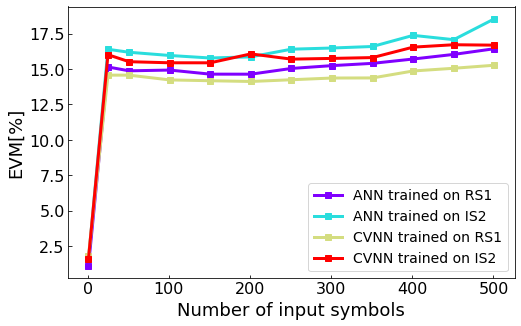

In [593]:
cm = plt.get_cmap('rainbow', 4)
fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot(1, 1, 1)
legends = ['ANN trained on RS1', 'ANN trained on IS2', 'CVNN trained on RS1', 'CVNN trained on IS2', 'ANN trained on RS2', 'ANN trained on IS3']
for i in range(4):
    ax.plot(taps, evms_tap0_t0[i], '-s', lw=3, color=[cm(i)[0], cm(i)[1], cm(i)[2]], label=legends[i])
plt.legend(fontsize=14, loc='lower right')
plt.xlabel('Number of input symbols', fontsize=18)
plt.ylabel('EVM[%]', fontsize=18)
#ax.set_xlim((-110000, 110000))
#ax.set_ylim((-110000, 110000))
ax.xaxis.set_tick_params(labelsize= 16, direction='in')
ax.yaxis.set_tick_params(labelsize= 16, direction='in')

In [568]:
taps = [1, 25, 51, 101, 151, 201, 251, 301, 351, 401, 451, 501]
evms_tap0_t1 = np.zeros((4, 11), dtype=float)
evms_tap1_t1 = np.zeros((2, 6), dtype=float)
for i, tap in enumerate(tqdm(taps)):
    model_info['model_type'] = 'ANN'
    model_info['activation'] = 'ReLU'
    x_test, y_test = prepare_input(model_info, signal_info_test1, tap, PdBm)
    nnc, y = predict_ANN(x_test, y_test, model_info, signal_info_model0, tap, PdBm)
    evms_tap0_t1[0, i] = evm_score(nnc, y) * 100
    nnc, y = predict_ANN(x_test, y_test, model_info, signal_info_model2, tap, PdBm)
    evms_tap0_t1[1, i] = evm_score(nnc, y) * 100
    
    model_info['model_type'] = 'CVNN'
    model_info['activation'] = 'CReLU'
    x_test, y_test = prepare_input(model_info, signal_info_test1, tap, PdBm)
    nnc, y = predict_CVNN(x_test, y_test, model_info, signal_info_model0, tap, PdBm)
    evms_tap0_t1[2, i] = evm_score(nnc, y) * 100
    nnc, y = predict_CVNN(x_test, y_test, model_info, signal_info_model2, tap, PdBm)
    evms_tap0_t1[3, i] = evm_score(nnc, y) * 100

指定された条件の学習結果は存在しません



UnboundLocalError: local variable 'model' referenced before assignment

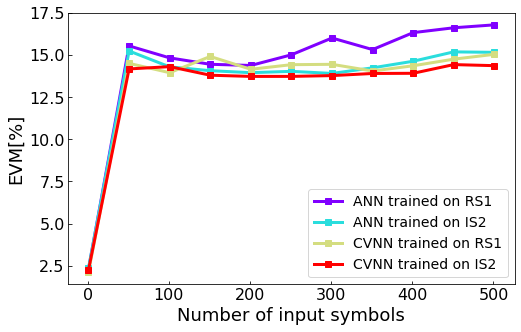

In [457]:
cm = plt.get_cmap('rainbow', 4)
fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot(1, 1, 1)
legends = ['ANN trained on RS1', 'ANN trained on IS2', 'CVNN trained on RS1', 'CVNN trained on IS2', 'ANN trained on RS2', 'ANN trained on IS3']
for i in range(4):
    if i < 4:
        ax.plot(taps0, evms_tap0_t1[i], '-s', lw=3, color=[cm(i)[0], cm(i)[1], cm(i)[2]], label=legends[i])
    else:
        ax.plot(taps1, evms_tap1_t1[i - 4], '-s', lw=3, color=[cm(i)[0], cm(i)[1], cm(i)[2]], label=legends[i])
plt.legend(fontsize=14, loc='lower right')
plt.xlabel('Number of input symbols', fontsize=18)
plt.ylabel('EVM[%]', fontsize=18)
#ax.set_xlim((-110000, 110000))
#ax.set_ylim((-110000, 110000))
ax.xaxis.set_tick_params(labelsize= 16, direction='in')
ax.yaxis.set_tick_params(labelsize= 16, direction='in')

## 2.5 epoch vs EVM

In [294]:
tap = 1
PdBm = 1
model_info = {'model_type': 'ANN',
                          'linear_compensation': True,
                          'sampling': 1,
                          'batch_size': 100,
                          'neuron': 320,
                          'epochs': 500,
                          'lr': 0.001,
                          'activation': 'ReLU',
                          'form': 'RZ16QAM',
                          'Lmax': 2500}
signal_info_model = {'signal_type': 'random', 'seed': 1234, 'bit_num': 50000}

signal_info_test = {'signal_type': 'prbs', 'N': 17, 'itr': 1}

In [295]:
epochs = [50, 100, 150, 200, 250, 300, 350, 400, 450, 500]
evms_activation = np.zeros((5, 10), dtype=float)
for i, epoch in enumerate(tqdm(epochs)):
    model_info['epochs'] = epoch
    
    model_info['model_type'] = 'ANN'
    x_test, y_test = prepare_input(model_info, signal_info_test, tap, PdBm)
    
    model_info['activation'] = 'Sigmoid'
    nnc, y = predict_ANN(x_test, y_test, model_info, signal_info_model, tap, PdBm)
    evms_activation[0, i] = evm_score(nnc, y) * 100
    
    model_info['activation'] = 'ReLU'
    nnc, y = predict_ANN(x_test, y_test, model_info, signal_info_model, tap, PdBm)
    evms_activation[1, i] = evm_score(nnc, y) * 100
    
    model_info['model_type'] = 'CVNN'
    x_test, y_test = prepare_input(model_info, signal_info_test, tap, PdBm)
    
    model_info['activation'] = 'CSigmoid'
    nnc, y = predict_CVNN(x_test, y_test, model_info, signal_info_model, tap, PdBm)
    evms_activation[2, i] = evm_score(nnc, y) * 100
    
    model_info['activation'] = 'CReLU'
    nnc, y = predict_CVNN(x_test, y_test, model_info, signal_info_model, tap, PdBm)
    evms_activation[3, i] = evm_score(nnc, y) * 100
    
    model_info['activation'] = 'modReLU'
    nnc, y = predict_CVNN(x_test, y_test, model_info, signal_info_model, tap, PdBm)
    evms_activation[4, i] = evm_score(nnc, y) * 100

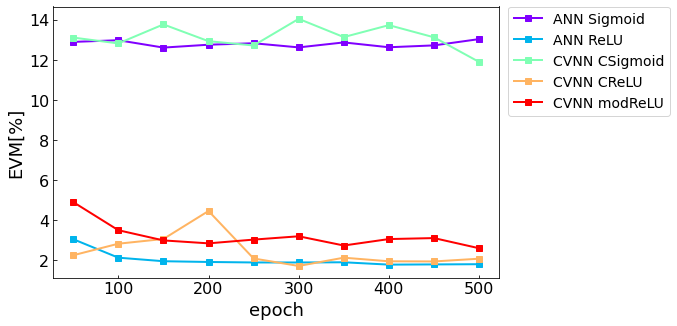

In [299]:
cm = plt.get_cmap('rainbow', 5)
fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot(1, 1, 1)
legends = ['ANN Sigmoid', 'ANN ReLU', 'CVNN CSigmoid', 'CVNN CReLU', 'CVNN modReLU']
for i in range(5):
    ax.plot(epochs, evms_activation[i], '-s', lw=2, color=[cm(i)[0], cm(i)[1], cm(i)[2]], label=legends[i])
plt.legend(fontsize=14, bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.xlabel('epoch', fontsize=18)
plt.ylabel('EVM[%]', fontsize=18)
#ax.set_xlim((-110000, 110000))
#ax.set_ylim((-110000, 110000))
ax.xaxis.set_tick_params(labelsize= 16, direction='in')
ax.yaxis.set_tick_params(labelsize= 16, direction='in')

## 2.6 サンプリング数 vs EVM

In [305]:
model_info_ann = {'model_type': 'ANN',
                          'linear_compensation': True,
                          'sampling': 1,
                          'batch_size': 100,
                          'neuron': 320,
                          'epochs': 500,
                          'lr': 0.001,
                          'activation': 'ReLU',
                          'form': 'RZ16QAM',
                          'Lmax': 2500}

model_info_cvnn = {'model_type': 'CVNN',
                          'linear_compensation': True,
                          'sampling': 1,
                          'batch_size': 100,
                          'neuron': 320,
                          'epochs': 500,
                          'lr': 0.001,
                          'activation': 'CReLU',
                          'form': 'RZ16QAM',
                          'Lmax': 2500}

signal_info_model0 = {'signal_type': 'random', 'seed': 1234, 'bit_num': 50000}
signal_info_model1 = {'signal_type': 'image', 'target_dir': 'train_0', 'step': 60, 'image_number': '0, 1, 2, 3, 4, 5, 6, 7, 8, 9', 'ebtb': True}
signal_info_model2 = {'signal_type': 'image', 'target_dir': 'train_0', 'step': 60, 'image_number': '0, 5, 6, 12, 17, 33, 35, 45, 52, 53', 'ebtb': True}

signal_info_test0 = {'signal_type': 'prbs', 'N': 17, 'itr': 1}
signal_info_test1 = {'signal_type': 'image', 'target_dir': 'train_0', 'step': 60, 'image_number': '10, 11, 13', 'ebtb': True}

In [309]:
tap = 1
PdBm = 1
samplings = [1, 2, 3, 4, 5]
evms_ann_t0 = np.zeros((3, 5), dtype=float)
for i, sampling in enumerate(tqdm(samplings)):
    model_info_ann['sampling'] = sampling
    
    x_test, y_test = prepare_input(model_info_ann, signal_info_test0, tap, PdBm)
    nnc, y = predict_ANN(x_test, y_test, model_info_ann, signal_info_model0, tap, PdBm)
    evms_ann_t0[0, i] = evm_score(nnc, y) * 100
    
    x_test, y_test = prepare_input(model_info_ann, signal_info_test0, tap, PdBm)
    nnc, y = predict_ANN(x_test, y_test, model_info_ann, signal_info_model1, tap, PdBm)
    evms_ann_t0[1, i] = evm_score(nnc, y) * 100
    
    x_test, y_test = prepare_input(model_info_ann, signal_info_test0, tap, PdBm)
    nnc, y = predict_ANN(x_test, y_test, model_info_ann, signal_info_model2, tap, PdBm)
    evms_ann_t0[2, i] = evm_score(nnc, y) * 100

In [319]:
tap = 1
PdBm = 1
samplings = [1, 2, 3, 4, 5]
evms_ann_t1 = np.zeros((3, 5), dtype=float)
for i, sampling in enumerate(tqdm(samplings)):
    model_info_ann['sampling'] = sampling
    
    x_test, y_test = prepare_input(model_info_ann, signal_info_test1, tap, PdBm)
    nnc, y = predict_ANN(x_test, y_test, model_info_ann, signal_info_model0, tap, PdBm)
    evms_ann_t1[0, i] = evm_score(nnc, y) * 100
    
    x_test, y_test = prepare_input(model_info_ann, signal_info_test1, tap, PdBm)
    nnc, y = predict_ANN(x_test, y_test, model_info_ann, signal_info_model1, tap, PdBm)
    evms_ann_t1[1, i] = evm_score(nnc, y) * 100
    
    x_test, y_test = prepare_input(model_info_ann, signal_info_test1, tap, PdBm)
    nnc, y = predict_ANN(x_test, y_test, model_info_ann, signal_info_model2, tap, PdBm)
    evms_ann_t1[2, i] = evm_score(nnc, y) * 100

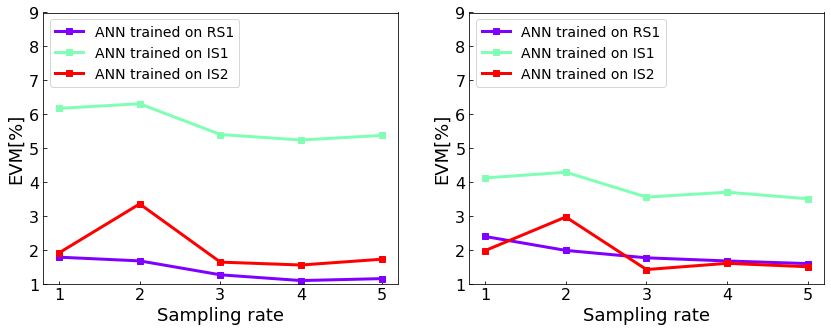

In [458]:
cm = plt.get_cmap('rainbow', 3)
fig = plt.figure(figsize=(14, 5))
ax0 = fig.add_subplot(1, 2, 1)
ax1 = fig.add_subplot(1, 2, 2)
legends = ['ANN trained on RS1', 'ANN trained on IS1', 'ANN trained on IS2']
for i in range(3):
    ax0.plot(samplings, evms_ann_t0[i], '-s', lw=3, color=[cm(i)[0], cm(i)[1], cm(i)[2]], label=legends[i])
    ax1.plot(samplings, evms_ann_t1[i], '-s', lw=3, color=[cm(i)[0], cm(i)[1], cm(i)[2]], label=legends[i])
ax0.legend(fontsize=14, loc='upper left')
ax0.set_xlabel('Sampling rate', fontsize=18)
ax0.set_ylabel('EVM[%]', fontsize=18)
ax1.legend(fontsize=14, loc='upper left')
ax1.set_xlabel('Sampling rate', fontsize=18)
ax1.set_ylabel('EVM[%]', fontsize=18)
ax0.set_ylim((1, 9))
ax1.set_ylim((1, 9))
ax0.xaxis.set_tick_params(labelsize= 16, direction='in')
ax0.yaxis.set_tick_params(labelsize= 16, direction='in')
ax1.xaxis.set_tick_params(labelsize= 16, direction='in')
ax1.yaxis.set_tick_params(labelsize= 16, direction='in')

In [313]:
tap = 1
PdBm = 1
samplings = [1, 2, 3, 4, 5]
evms_cvnn_t0 = np.zeros((3, 5), dtype=float)
for i, sampling in enumerate(tqdm(samplings)):
    model_info_cvnn['sampling'] = sampling
    
    x_test, y_test = prepare_input(model_info_cvnn, signal_info_test0, tap, PdBm)
    nnc, y = predict_CVNN(x_test, y_test, model_info_cvnn, signal_info_model0, tap, PdBm)
    evms_cvnn_t0[0, i] = evm_score(nnc, y) * 100
    
    x_test, y_test = prepare_input(model_info_cvnn, signal_info_test0, tap, PdBm)
    nnc, y = predict_CVNN(x_test, y_test, model_info_cvnn, signal_info_model1, tap, PdBm)
    evms_cvnn_t0[1, i] = evm_score(nnc, y) * 100
    
    x_test, y_test = prepare_input(model_info_cvnn, signal_info_test0, tap, PdBm)
    nnc, y = predict_CVNN(x_test, y_test, model_info_cvnn, signal_info_model2, tap, PdBm)
    evms_cvnn_t0[2, i] = evm_score(nnc, y) * 100

In [317]:
tap = 1
PdBm = 1
samplings = [1, 2, 3, 4, 5]
evms_cvnn_t1 = np.zeros((3, 5), dtype=float)
for i, sampling in enumerate(tqdm(samplings)):
    model_info_cvnn['sampling'] = sampling
    
    x_test, y_test = prepare_input(model_info_cvnn, signal_info_test1, tap, PdBm)
    nnc, y = predict_CVNN(x_test, y_test, model_info_cvnn, signal_info_model0, tap, PdBm)
    evms_cvnn_t1[0, i] = evm_score(nnc, y) * 100
    
    x_test, y_test = prepare_input(model_info_cvnn, signal_info_test1, tap, PdBm)
    nnc, y = predict_CVNN(x_test, y_test, model_info_cvnn, signal_info_model1, tap, PdBm)
    evms_cvnn_t1[1, i] = evm_score(nnc, y) * 100
    
    x_test, y_test = prepare_input(model_info_cvnn, signal_info_test1, tap, PdBm)
    nnc, y = predict_CVNN(x_test, y_test, model_info_cvnn, signal_info_model2, tap, PdBm)
    evms_cvnn_t1[2, i] = evm_score(nnc, y) * 100

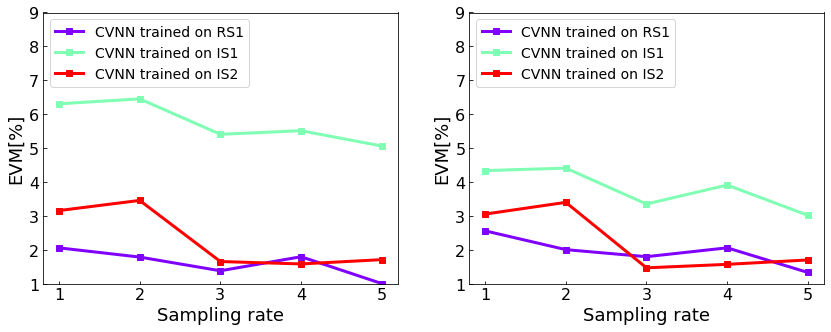

In [459]:
cm = plt.get_cmap('rainbow', 3)
fig = plt.figure(figsize=(14, 5))
ax0 = fig.add_subplot(1, 2, 1)
ax1 = fig.add_subplot(1, 2, 2)
legends = ['CVNN trained on RS1', 'CVNN trained on IS1', 'CVNN trained on IS2']
for i in range(3):
    ax0.plot(samplings, evms_cvnn_t0[i], '-s', lw=3, color=[cm(i)[0], cm(i)[1], cm(i)[2]], label=legends[i])
    ax1.plot(samplings, evms_cvnn_t1[i], '-s', lw=3, color=[cm(i)[0], cm(i)[1], cm(i)[2]], label=legends[i])
ax0.legend(fontsize=14, loc='upper left')
ax0.set_xlabel('Sampling rate', fontsize=18)
ax0.set_ylabel('EVM[%]', fontsize=18)
ax1.legend(fontsize=14, loc='upper left')
ax1.set_xlabel('Sampling rate', fontsize=18)
ax1.set_ylabel('EVM[%]', fontsize=18)
ax0.set_ylim((1, 9))
ax1.set_ylim((1, 9))
ax0.xaxis.set_tick_params(labelsize= 16, direction='in')
ax0.yaxis.set_tick_params(labelsize= 16, direction='in')
ax1.xaxis.set_tick_params(labelsize= 16, direction='in')
ax1.yaxis.set_tick_params(labelsize= 16, direction='in')

## 2.7 ANNとDBPの比較

In [508]:
model_info_ann = {'model_type': 'ANN',
                          'linear_compensation': True,
                          'sampling': 4,
                          'batch_size': 100,
                          'neuron': 320,
                          'epochs': 500,
                          'lr': 0.001,
                          'activation': 'ReLU',
                          'form': 'RZ16QAM',
                          'Lmax': 5000}

model_info_cvnn = {'model_type': 'CVNN',
                          'linear_compensation': True,
                          'sampling': 4,
                          'batch_size': 100,
                          'neuron': 320,
                          'epochs': 500,
                          'lr': 0.001,
                          'activation': 'CReLU',
                          'form': 'RZ16QAM',
                          'Lmax': 5000}

signal_info_model0 = {'signal_type': 'random', 'seed': 1234, 'bit_num': 50000}

signal_info_test0 = {'signal_type': 'prbs', 'N': 17, 'itr': 1}
signal_info_test1 = {'signal_type': 'image', 'target_dir': 'train_0', 'step': 60, 'image_number': '10', 'ebtb': True}
signal_info_test2 = {'signal_type': 'image', 'target_dir': 'train_0', 'step': 60, 'image_number': '10', 'ebtb': False}
signal_info_test3 = {'signal_type': 'image', 'target_dir': 'train', 'step': 10, 'image_number': '9', 'ebtb': True}
signal_info_test4 = {'signal_type': 'image', 'target_dir': 'train', 'step': 10, 'image_number': '9', 'ebtb': False}

base = 14.9

In [564]:
tap = 1
PdBm = 1
Ls = [1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000]
evms_L_t0 = np.zeros((5, 10), dtype=float)
dbp_evm0 = np.loadtxt('../data/dbp/result_PRBS_L.csv')
dbp_evm1 = np.loadtxt('../data/dbp/result_sa4_step30.csv')
for i, L in enumerate(tqdm(Ls)):
    evms_L_t0[0, i] = dbp_evm0[i]
    evms_L_t0[1, i] = dbp_evm1[i]
    
    model_info_ann['Lmax'] = L
    model_info_cvnn['Lmax'] = L
    
    model_info_ann['neuron'] = 10
    x_test, y_test = prepare_input(model_info_ann, signal_info_test0, tap, PdBm)
    nnc, y = predict_ANN(x_test, y_test, model_info_ann, signal_info_model0, tap, PdBm)
    evms_L_t0[2, i] = evm_score(nnc, y) * 100
    
    model_info_ann['neuron'] = 320
    x_test, y_test = prepare_input(model_info_ann, signal_info_test0, tap, PdBm)
    nnc, y = predict_ANN(x_test, y_test, model_info_ann, signal_info_model0, tap, PdBm)
    evms_L_t0[3, i] = evm_score(nnc, y) * 100
    
    x_test, y_test = prepare_input(model_info_cvnn, signal_info_test0, tap, PdBm)
    nnc, y = predict_CVNN(x_test, y_test, model_info_cvnn, signal_info_model0, tap, PdBm)
    evms_L_t0[4, i] = evm_score(nnc, y) * 100

In [487]:
print(evms_L_t0)

[[ 6.28278697  9.7923423  10.36375873 11.45894193 12.67949655 13.98604614
  15.93079116 15.97798473 16.92762431 17.87891695]
 [ 3.95519619  5.86200153  6.85620139  8.16669757  8.91816323  9.55799259
  10.44368464 10.64753268 11.16191424 11.72059994]
 [ 0.24688037  0.52243495  0.34431203  0.43513842  0.62986976  0.98391985
   1.10244378  1.34795063  2.01274174  2.61497916]
 [ 0.80425322  0.71760907  0.88488078  0.78793094  0.924993    1.10590863
   1.15363431  1.37660618  2.09967743  2.60471786]]


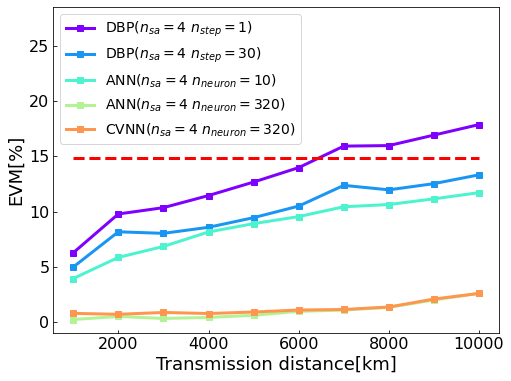

In [567]:
cm = plt.get_cmap('rainbow', 6)
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(1, 1, 1)
legends = ['DBP($n_{sa}=4$ $n_{step}=1$)', 'DBP($n_{sa}=4$ $n_{step}=30$)', 'ANN($n_{sa}=4$ $n_{neuron}=10$)', 'ANN($n_{sa}=4$ $n_{neuron}=320$)', 'CVNN($n_{sa}=4$ $n_{neuron}=320$)']
for i in range(5):
    ax.plot(Ls, evms_L_t0[i], '-s', lw=3, color=[cm(i)[0], cm(i)[1], cm(i)[2]], label=legends[i])
ax.plot(Ls, [base] * 10, '--', lw=3, color=[cm(i+1)[0], cm(i+1)[1], cm(i+1)[2]])
plt.legend(fontsize=14, loc='upper left')
plt.xlabel('Transmission distance[km]', fontsize=18)
plt.ylabel('EVM[%]', fontsize=18)
#ax.set_xlim((-110000, 110000))
ax.set_ylim((-1, 28.5))
ax.xaxis.set_tick_params(labelsize= 16, direction='in')
ax.yaxis.set_tick_params(labelsize= 16, direction='in')

In [374]:
tap = 1
PdBm = 1
Ls = [1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000]
evms_L_t1 = np.zeros((4, 10), dtype=float)
dbp_evm = np.loadtxt('../data/dbp/result_IS10_8B10B_L.csv')
for i, L in enumerate(tqdm(Ls)):
    evms_L_t1[0, i] = dbp_evm[i]
    
    model_info_ann['Lmax'] = L
    model_info_cvnn['Lmax'] = L
    
    model_info_ann['neuron'] = 10
    x_test, y_test = prepare_input(model_info_ann, signal_info_test1, tap, PdBm)
    nnc, y = predict_ANN(x_test, y_test, model_info_ann, signal_info_model0, tap, PdBm)
    evms_L_t1[1, i] = evm_score(nnc, y) * 100
    
    model_info_ann['neuron'] = 320
    x_test, y_test = prepare_input(model_info_ann, signal_info_test1, tap, PdBm)
    nnc, y = predict_ANN(x_test, y_test, model_info_ann, signal_info_model0, tap, PdBm)
    evms_L_t1[2, i] = evm_score(nnc, y) * 100
    
    x_test, y_test = prepare_input(model_info_cvnn, signal_info_test1, tap, PdBm)
    nnc, y = predict_CVNN(x_test, y_test, model_info_cvnn, signal_info_model0, tap, PdBm)
    evms_L_t1[3, i] = evm_score(nnc, y) * 100

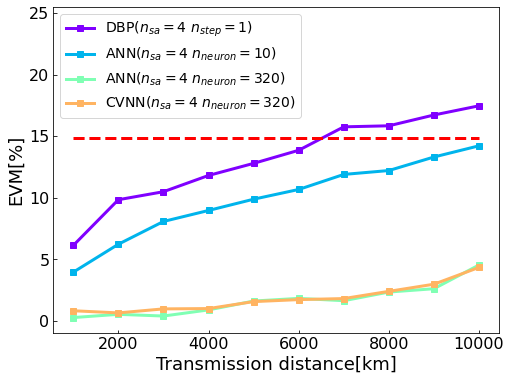

In [511]:
cm = plt.get_cmap('rainbow', 5)
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(1, 1, 1)
legends = ['DBP($n_{sa}=4$ $n_{step}=1$)', 'ANN($n_{sa}=4$ $n_{neuron}=10$)', 'ANN($n_{sa}=4$ $n_{neuron}=320$)', 'CVNN($n_{sa}=4$ $n_{neuron}=320$)']
for i in range(4):
    ax.plot(Ls, evms_L_t1[i], '-s', lw=3, color=[cm(i)[0], cm(i)[1], cm(i)[2]], label=legends[i])
ax.plot(Ls, [base] * 10, '--', lw=3, color=[cm(i+1)[0], cm(i+1)[1], cm(i+1)[2]])
plt.legend(fontsize=14, loc='upper left')
plt.xlabel('Transmission distance[km]', fontsize=18)
plt.ylabel('EVM[%]', fontsize=18)
#ax.set_xlim((-110000, 110000))
ax.set_ylim((-1, 25.5))
ax.xaxis.set_tick_params(labelsize= 16, direction='in')
ax.yaxis.set_tick_params(labelsize= 16, direction='in')

In [381]:
tap = 1
PdBm = 1
Ls = [1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000]
evms_L_t2 = np.zeros((4, 10), dtype=float)
dbp_evm = np.loadtxt('../data/dbp/result_IS10_L.csv')
for i, L in enumerate(tqdm(Ls)):
    evms_L_t2[0, i] = dbp_evm[i]
    
    model_info_ann['Lmax'] = L
    model_info_cvnn['Lmax'] = L
    
    model_info_ann['neuron'] = 10
    x_test, y_test = prepare_input(model_info_ann, signal_info_test2, tap, PdBm)
    nnc, y = predict_ANN(x_test, y_test, model_info_ann, signal_info_model0, tap, PdBm)
    evms_L_t2[1, i] = evm_score(nnc, y) * 100
    
    model_info_ann['neuron'] = 320
    x_test, y_test = prepare_input(model_info_ann, signal_info_test2, tap, PdBm)
    nnc, y = predict_ANN(x_test, y_test, model_info_ann, signal_info_model0, tap, PdBm)
    evms_L_t2[2, i] = evm_score(nnc, y) * 100
    
    x_test, y_test = prepare_input(model_info_cvnn, signal_info_test2, tap, PdBm)
    nnc, y = predict_CVNN(x_test, y_test, model_info_cvnn, signal_info_model0, tap, PdBm)
    evms_L_t2[3, i] = evm_score(nnc, y) * 100

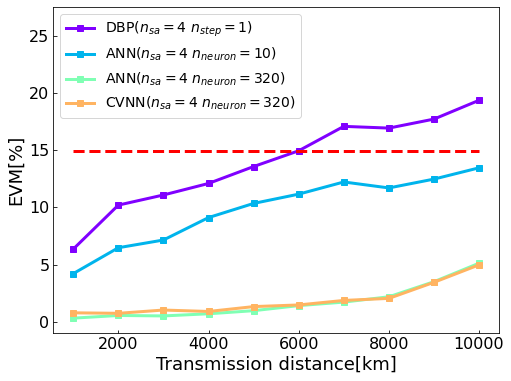

In [512]:
cm = plt.get_cmap('rainbow', 5)
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(1, 1, 1)
legends = ['DBP($n_{sa}=4$ $n_{step}=1$)', 'ANN($n_{sa}=4$ $n_{neuron}=10$)', 'ANN($n_{sa}=4$ $n_{neuron}=320$)', 'CVNN($n_{sa}=4$ $n_{neuron}=320$)']
for i in range(4):
    ax.plot(Ls, evms_L_t2[i], '-s', lw=3, color=[cm(i)[0], cm(i)[1], cm(i)[2]], label=legends[i])
ax.plot(Ls, [base] * 10, '--', lw=3, color=[cm(i+1)[0], cm(i+1)[1], cm(i+1)[2]])
plt.legend(fontsize=14, loc='upper left')
plt.xlabel('Transmission distance[km]', fontsize=18)
plt.ylabel('EVM[%]', fontsize=18)
#ax.set_xlim((-110000, 110000))
ax.set_ylim((-1, 27.5))
ax.xaxis.set_tick_params(labelsize= 16, direction='in')
ax.yaxis.set_tick_params(labelsize= 16, direction='in')

In [542]:
tap = 1
PdBm = 1
Ls = [1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000]
evms_L_t3 = np.zeros((4, 10), dtype=float)
dbp_evm = np.loadtxt('../data/dbp/result_IS9_8B10B_L.csv')
for i, L in enumerate(tqdm(Ls)):
    evms_L_t3[0, i] = dbp_evm[i]
    
    model_info_ann['Lmax'] = L
    model_info_cvnn['Lmax'] = L
    
    model_info_ann['neuron'] = 10
    x_test, y_test = prepare_input(model_info_ann, signal_info_test3, tap, PdBm)
    nnc, y = predict_ANN(x_test, y_test, model_info_ann, signal_info_model0, tap, PdBm)
    evms_L_t3[1, i] = evm_score(nnc, y) * 100
    
    model_info_ann['neuron'] = 320
    x_test, y_test = prepare_input(model_info_ann, signal_info_test3, tap, PdBm)
    nnc, y = predict_ANN(x_test, y_test, model_info_ann, signal_info_model0, tap, PdBm)
    evms_L_t3[2, i] = evm_score(nnc, y) * 100
    
    x_test, y_test = prepare_input(model_info_cvnn, signal_info_test3, tap, PdBm)
    nnc, y = predict_CVNN(x_test, y_test, model_info_cvnn, signal_info_model0, tap, PdBm)
    evms_L_t3[3, i] = evm_score(nnc, y) * 100

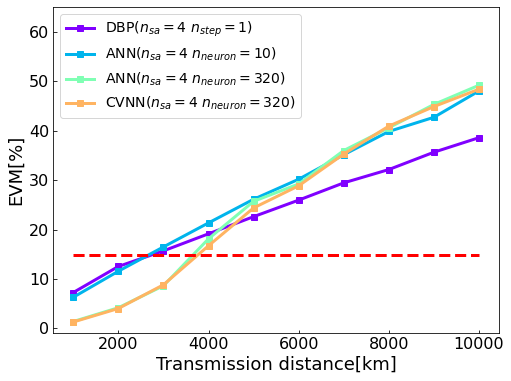

In [550]:
cm = plt.get_cmap('rainbow', 5)
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(1, 1, 1)
legends = ['DBP($n_{sa}=4$ $n_{step}=1$)', 'ANN($n_{sa}=4$ $n_{neuron}=10$)', 'ANN($n_{sa}=4$ $n_{neuron}=320$)', 'CVNN($n_{sa}=4$ $n_{neuron}=320$)']
for i in range(4):
    ax.plot(Ls, evms_L_t3[i], '-s', lw=3, color=[cm(i)[0], cm(i)[1], cm(i)[2]], label=legends[i])
ax.plot(Ls, [base] * 10, '--', lw=3, color=[cm(i+1)[0], cm(i+1)[1], cm(i+1)[2]])
plt.legend(fontsize=14, loc='upper left')
plt.xlabel('Transmission distance[km]', fontsize=18)
plt.ylabel('EVM[%]', fontsize=18)
#ax.set_xlim((-110000, 110000))
ax.set_ylim((-1, 65))
ax.xaxis.set_tick_params(labelsize= 16, direction='in')
ax.yaxis.set_tick_params(labelsize= 16, direction='in')

In [537]:
tap = 1
PdBm = 1
Ls = [1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000]
evms_L_t4 = np.zeros((4, 10), dtype=float)
dbp_evm = np.loadtxt('../data/dbp/result_IS9_L.csv')
for i, L in enumerate(tqdm(Ls)):
    evms_L_t4[0, i] = dbp_evm[i]
    
    model_info_ann['Lmax'] = L
    model_info_cvnn['Lmax'] = L
    
    model_info_ann['neuron'] = 10
    x_test, y_test = prepare_input(model_info_ann, signal_info_test4, tap, PdBm)
    nnc, y = predict_ANN(x_test, y_test, model_info_ann, signal_info_model0, tap, PdBm)
    evms_L_t4[1, i] = evm_score(nnc, y) * 100
    
    model_info_ann['neuron'] = 320
    x_test, y_test = prepare_input(model_info_ann, signal_info_test4, tap, PdBm)
    nnc, y = predict_ANN(x_test, y_test, model_info_ann, signal_info_model0, tap, PdBm)
    evms_L_t4[2, i] = evm_score(nnc, y) * 100
    
    x_test, y_test = prepare_input(model_info_cvnn, signal_info_test4, tap, PdBm)
    nnc, y = predict_CVNN(x_test, y_test, model_info_cvnn, signal_info_model0, tap, PdBm)
    evms_L_t4[3, i] = evm_score(nnc, y) * 100

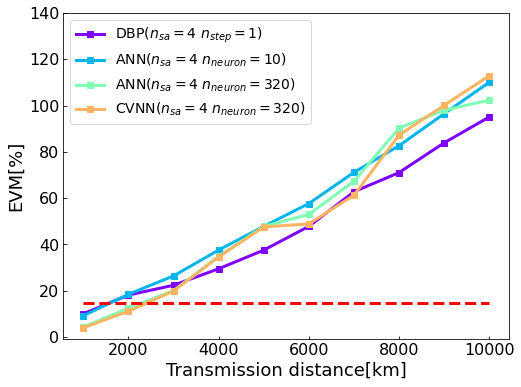

In [553]:
cm = plt.get_cmap('rainbow', 5)
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(1, 1, 1)
legends = ['DBP($n_{sa}=4$ $n_{step}=1$)', 'ANN($n_{sa}=4$ $n_{neuron}=10$)', 'ANN($n_{sa}=4$ $n_{neuron}=320$)', 'CVNN($n_{sa}=4$ $n_{neuron}=320$)']
for i in range(4):
    ax.plot(Ls, evms_L_t4[i], '-s', lw=3, color=[cm(i)[0], cm(i)[1], cm(i)[2]], label=legends[i])
ax.plot(Ls, [base] * 10, '--', lw=3, color=[cm(i+1)[0], cm(i+1)[1], cm(i+1)[2]])
plt.legend(fontsize=14, loc='upper left')
plt.xlabel('Transmission distance[km]', fontsize=18)
plt.ylabel('EVM[%]', fontsize=18)
#ax.set_xlim((-110000, 110000))
ax.set_ylim((-1, 140))
ax.xaxis.set_tick_params(labelsize= 16, direction='in')
ax.yaxis.set_tick_params(labelsize= 16, direction='in')

In [562]:
print(evms_L_t4)
print(evms_L_t3)

[[ 10.06160802  18.12770853  22.36310502  29.49038376  37.55176418
   47.81812544  62.77608925  71.05916149  83.9241227   95.08724846]
 [  9.20627264  18.47894944  26.40020372  37.58753329  47.82176138
   57.68662644  71.15196496  82.67266575  96.49809219 110.1093152 ]
 [  4.31667554  12.4802789   20.01872894  34.90540542  47.76429786
   53.0028615   67.30987386  90.30788239  97.98262787 102.38522569]
 [  4.02662717  11.14831429  19.89606412  34.58685844  47.57969998
   48.89579271  61.27934864  87.23559131 100.13499728 112.93354191]]
[[ 7.24902924 12.52518648 15.67994345 19.13384558 22.60413712 25.95032714
  29.44455547 32.14049817 35.64919242 38.58752392]
 [ 6.28691885 11.5626727  16.47816676 21.3406261  26.12556231 30.17856496
  35.14159145 39.84589575 42.71403986 48.04985193]
 [ 1.38379069  4.17505743  8.61906025 18.12449132 25.70488839 29.22206013
  35.98886443 40.59088065 45.31679326 49.20076491]
 [ 1.28491572  4.01691275  8.81397602 16.71996742 24.37176876 28.85017979
  35.28043

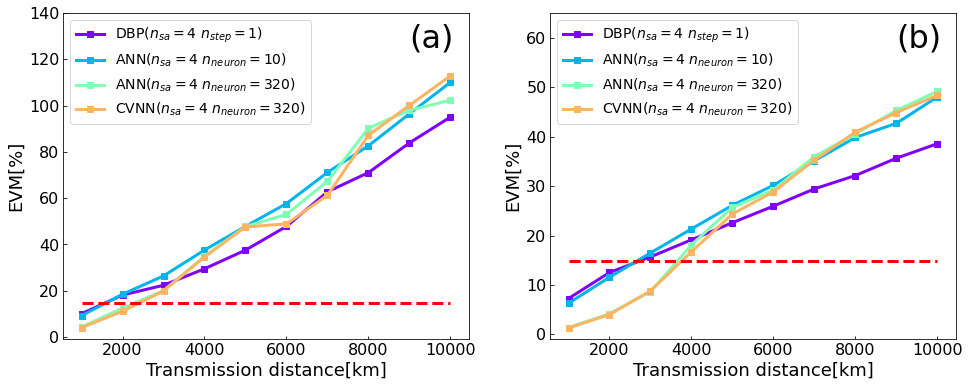

In [560]:
cm = plt.get_cmap('rainbow', 5)
fig = plt.figure(figsize=(16, 6))
ax0 = fig.add_subplot(1, 2, 1)
ax1= fig.add_subplot(1, 2, 2)
legends = ['DBP($n_{sa}=4$ $n_{step}=1$)', 'ANN($n_{sa}=4$ $n_{neuron}=10$)', 'ANN($n_{sa}=4$ $n_{neuron}=320$)', 'CVNN($n_{sa}=4$ $n_{neuron}=320$)']
for i in range(4):
    ax0.plot(Ls, evms_L_t4[i], '-s', lw=3, color=[cm(i)[0], cm(i)[1], cm(i)[2]], label=legends[i])
    ax1.plot(Ls, evms_L_t3[i], '-s', lw=3, color=[cm(i)[0], cm(i)[1], cm(i)[2]], label=legends[i])
ax0.plot(Ls, [base] * 10, '--', lw=3, color=[cm(i+1)[0], cm(i+1)[1], cm(i+1)[2]])
ax1.plot(Ls, [base] * 10, '--', lw=3, color=[cm(i+1)[0], cm(i+1)[1], cm(i+1)[2]])
ax0.text(9000, 125, '(a)', color='black', fontsize=32)
ax1.text(9000, 58, '(b)', color='black', fontsize=32)
ax0.legend(fontsize=14, loc='upper left')
ax1.legend(fontsize=14, loc='upper left')
ax0.set_xlabel('Transmission distance[km]', fontsize=18)
ax0.set_ylabel('EVM[%]', fontsize=18)
ax1.set_xlabel('Transmission distance[km]', fontsize=18)
ax1.set_ylabel('EVM[%]', fontsize=18)
ax0.set_ylim((-1, 140))
ax1.set_ylim((-1, 65))
ax0.xaxis.set_tick_params(labelsize= 16, direction='in')
ax0.yaxis.set_tick_params(labelsize= 16, direction='in')
ax1.xaxis.set_tick_params(labelsize= 16, direction='in')
ax1.yaxis.set_tick_params(labelsize= 16, direction='in')

In [575]:
tap = 1
model_info_ann['Lmax'] = 5000
model_info_cvnn['Lmax'] = 5000
PdBms = [-5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5]
evms_PdBm_t0 = np.zeros((5, 11), dtype=float)
dbp_evm0 = np.loadtxt('../data/dbp/result_PRBS_PdBm.csv')
dbp_evm1 = np.loadtxt('../data/dbp/result_sa4_step30_PdBm.csv')
for i, PdBm in enumerate(tqdm(PdBms)):
    evms_PdBm_t0[0, i] = dbp_evm0[i]
    evms_PdBm_t0[1, i] = dbp_evm1[i]
    
    model_info_ann['neuron'] = 10
    x_test, y_test = prepare_input(model_info_ann, signal_info_test0, tap, PdBm)
    nnc, y = predict_ANN(x_test, y_test, model_info_ann, signal_info_model0, tap, PdBm)
    evms_PdBm_t0[2, i] = evm_score(nnc, y) * 100
    
    model_info_ann['neuron'] = 320
    x_test, y_test = prepare_input(model_info_ann, signal_info_test0, tap, PdBm)
    nnc, y = predict_ANN(x_test, y_test, model_info_ann, signal_info_model0, tap, PdBm)
    evms_PdBm_t0[3, i] = evm_score(nnc, y) * 100
    
    x_test, y_test = prepare_input(model_info_cvnn, signal_info_test0, tap, PdBm)
    nnc, y = predict_CVNN(x_test, y_test, model_info_cvnn, signal_info_model0, tap, PdBm)
    evms_PdBm_t0[4, i] = evm_score(nnc, y) * 100

In [532]:
print(evms_PdBm_t0)

[[17.9181445  16.18551287 14.64449898 13.39408939 12.67993233 12.38394444
  12.67949655 13.67948815 15.60435455 18.48357682 22.38728944]
 [10.16993862  9.71001867  9.2511812   8.5284988   8.19037391  8.6024369
   8.91816323 10.02813929 11.22008876 14.04728668 16.63565095]
 [ 1.58643773  1.05800028  1.30026851  0.49942047  0.50848071  0.69999312
   0.62986976  0.91000192  2.10726002  4.21767272  8.43190045]
 [ 1.61871617  1.24793123  1.06160562  0.84562806  0.70857581  0.86113643
   0.924993    1.09812445  1.77995376  4.20797829  8.81132479]]


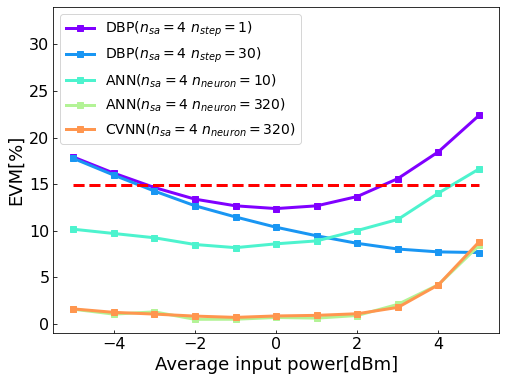

In [578]:
cm = plt.get_cmap('rainbow', 6)
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(1, 1, 1)
legends = ['DBP($n_{sa}=4$ $n_{step}=1$)', 'DBP($n_{sa}=4$ $n_{step}=30$)', 'ANN($n_{sa}=4$ $n_{neuron}=10$)', 'ANN($n_{sa}=4$ $n_{neuron}=320$)', 'CVNN($n_{sa}=4$ $n_{neuron}=320$)']
for i in range(5):
    ax.plot(PdBms, evms_PdBm_t0[i], '-s', lw=3, color=[cm(i)[0], cm(i)[1], cm(i)[2]], label=legends[i])
ax.plot(PdBms, [base] * 11, '--', lw=3, color=[cm(i+1)[0], cm(i+1)[1], cm(i+1)[2]])
plt.legend(fontsize=14, loc='upper left')
plt.xlabel('Average input power[dBm]', fontsize=18)
plt.ylabel('EVM[%]', fontsize=18)
#ax.set_xlim((-110000, 110000))
ax.set_ylim((-1, 34))
ax.xaxis.set_tick_params(labelsize= 16, direction='in')
ax.yaxis.set_tick_params(labelsize= 16, direction='in')